# Exercise 1
---

In [13]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sbn
import numpy as np
import math
sbn.set() 

# *Step 1: Implementing the Linear Congruential Generator (LCG) as well as all of the statistical tests that will test it's performance*

In [14]:
def LCG(a, c, M, x0, n):
    x = np.zeros(n)
    x[0] = x0

    for i in range(1, n):
        x[i] = int((a * x[i - 1] + c ) % M)

    return x.astype(int)

def test_chi_square(data, num_bins):
    # Initialize bins
    bins = [0] * num_bins
    
    # Populate the bins with frequency counts
    for number in data:
        bin_index = int(number * num_bins)
        if bin_index == num_bins:  # Edge case for the maximum value
            bin_index -= 1
        bins[bin_index] += 1

    # Expected frequency per bin for uniform distribution
    expected_freq = len(data) / num_bins
    expected = [expected_freq] * num_bins

    # Chi-square test
    Z = sum((o - e) ** 2 / e for o, e in zip(bins, expected))

    p = 1 - stats.chi2.cdf(Z, df = num_bins - 1)
    
    return Z, p  # (test statistic, p-value)


def test_ks(U):
    n = U.shape[0]

    Fxn = U.copy()
    Fxn.sort()

    Fx = np.linspace(0, 1, n)
    
    Dn = np.abs(Fxn - Fx).max()
    Dn_a = (np.sqrt(n) + .12 + .11 / np.sqrt(n)) * Dn

    # p_value
    p = 1 - stats.kstwobign.cdf(Dn_a)

    return Dn_a, p

def test_above_below(U):
    n = U.shape[0]
    mid = np.median(U)

    n1 = np.sum(U > mid)
    n2 = np.sum(U < mid)

    mean_ = 2 * n1 * n2 / (n1 + n2)
    var_ = (2 * n1 * n2) * (2 * n1 * n2 - n1 - n2) / ((n1 + n2) ** 2 * (n1 + n2 - 1))

    diffs = np.sign(U - mid)

    Ra = np.sum((diffs[:-1] <= 0) & (diffs[1:] > 0))
    Rb = np.sum((diffs[:-1] >= 0) & (diffs[1:] < 0))

    if diffs[0] > 0:
        Ra += 1
    elif diffs[0] < 0:
        Rb += 1

    Z = Ra + Rb
    
    p = 2 * (1 - stats.norm.cdf(np.abs(Z - mean_), scale=np.sqrt(var_)))

    return Z, p

def test_up_down_knuth(data):
    n = len(data)
    run_counts = np.zeros(6, dtype=int)  # Initialize run counts

    current_run = 1
    for i in range(1, n):
        if data[i] >= data[i - 1]:
            current_run += 1
        else:
            if current_run > 5:
                run_counts[5] += 1
            else:
                run_counts[current_run - 1] += 1
            current_run = 1

    # Precalculated constants for the test
    expected_runs = np.array([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840])
    covariance_matrix = np.array([
        [4529.4, 9044.9, 13568, 18091, 22615, 27892],
        [9044.9, 18097, 27139, 36187, 45234, 55789],
        [13568, 27139, 40721, 54281, 67852, 83685],
        [18091, 36187, 54281, 72414, 90470, 111580],
        [22615, 45234, 67852, 90470, 113262, 139476],
        [27892, 55789, 83685, 111580, 139476, 172860]
    ])

    run_counts = run_counts.reshape(-1, 1)
    expected_runs = expected_runs.reshape(-1, 1)

    test_statistic = (1 / (n - 6)) * (run_counts - n * expected_runs).T @ covariance_matrix @ (run_counts - n * expected_runs)
    p_value = 1 - stats.chi2.cdf(test_statistic, df=6)

    return test_statistic[0, 0], p_value[0, 0]

def test_up_down_rubenstein(U):
    n = U.shape[0]
    
    runs = 1  # Start with the first run
    cur_direction = U[0] <= U[1]  # True if the current direction is upwards

    for i in range(1, n - 1):
        if (U[i] <= U[i + 1]) != cur_direction:  # Change in direction detected
            runs += 1
            cur_direction = not cur_direction  # Toggle the direction

    # Calculate Z test statistic
    Z = (runs - (2 * n - 1) / 3) / np.sqrt((16 * n - 29) / 90)
    
    p = 2 * (1 - stats.norm.cdf(np.abs(Z)))  # Compute the two-tailed p-value

    return Z, p

def test_correlation(U, h=1):

    n = len(U)
    # Calculate the Pearson correlation coefficient for U and U shifted by h
    if h >= n:
        return None, None  # Return None if the lag is too large
    
    # Correlation between U and lagged U
    correlation, _ = stats.pearsonr(U[:-h], U[h:])
    
    # Convert correlation to t-statistic for testing non-zero correlation
    t_stat = correlation * np.sqrt((n - 2 - h) / (1 - correlation**2))
    
    # Two-tailed p-value from the t-distribution
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 2 - h))
    
    return correlation, p_value

def run_all_tests(U):
    Z, p = test_chi_square(U,20)
    print(f'Chi-square test: test-statistic: {Z}, p-value: {p}')
    Z, p = test_ks(U)
    print(f'Kolmogorov-Smirnov test: test-statistic: {Z}, p-value: {p}')
    Z, p = test_above_below(U)
    print(f'Run test I (Above-Below): test-statistic: {Z}, p-value: {p}')
    Z, p = test_up_down_knuth(U)
    print(f'Run test II (Up-Down Knuth): test-statistic: {Z}, p-value: {p}')
    Z, p = test_up_down_rubenstein(U)
    print(f'Run test III (Up-Down Rubenstein): test-statistic: {Z}, p-value: {p}')
    Z, p = test_correlation(U, h = 2)
    print(f'Correlation test: test-statistic: {Z}, p-value: {p}')

*(1a) Generate 10 000 pseudo-random numbers*

Now we will generate 10000 random integers on the same starting values as in the slideshow

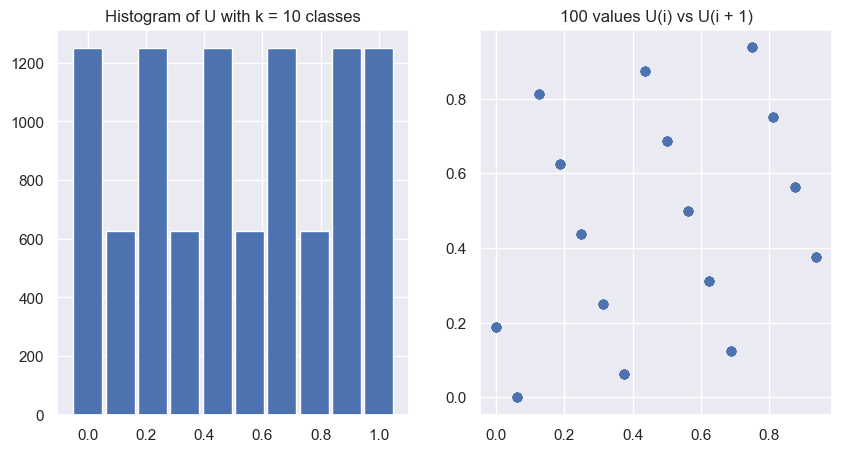

In [15]:
# Parameter values
n = 10000
x0 = 3
M = 16
a = 5
c = 1
k = 10 # Number of classes

# Generating and 
X = LCG(a = a, c = c, M = M, x0 = x0, n = n)
U = X / M

# Plotting
heights = np.histogram(U, bins = k)[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(np.linspace(0, 1, k), height = heights, width = .1, )
ax[0].set_title(f'Histogram of U with k = {k} classes')
ax[1].scatter(U[:100][1:], U[:100][:-1])
ax[1].set_title(f'100 values U(i) vs U(i + 1)')
plt.show()

As we can see in the histogram and a scatterplot, the starting values given in the slideshow do not produce a desirable pseudo random numbers. We can clearly see that the distribution in the histogram favours some of the bins as well as we can see that scatterplot is too uniform. It indicates high correlation among values. All of the observations from visual cues are proved by the statistical evaluation below

*(b) Evaluate quality of generators*

In [16]:
run_all_tests(U)

Chi-square test: test-statistic: 2500.0, p-value: 0.0
Kolmogorov-Smirnov test: test-statistic: 6.25756875, p-value: 0.0
Run test I (Above-Below): test-statistic: 3750, p-value: 0.0
Run test II (Up-Down Knuth): test-statistic: 1121.792788421887, p-value: 0.0
Run test III (Up-Down Rubenstein): test-statistic: -9.875106965999812, p-value: 0.0
Correlation test: test-statistic: -0.03526621028400208, p-value: 0.0004204166716335056


Based on the results, we can conclude that the Chi-square, Kolmogorov-Smirnov, and run tests all lead us to reject the null hypothesis that the pseudo-random numbers follow a uniform distribution at the significance level $\alpha = 0.05$. This outcome supports the initial suspicion from the visual inspection of histograms and correlation plots.

*(c) Testing another LCG parameters*

Previously we have rejected the starting variables from the slides, now let's try different ones. After careful concideration and testing some values we thinks that those will do the trick:
$M = 2^{48} $,
$a = 25214903917$,
$c = 11$,
$x_0 = 3$

/Users/krzysztofsawicki/opt/anaconda3/envs/ml02450/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/krzysztofsawicki/opt/anaconda3/envs/ml02450/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


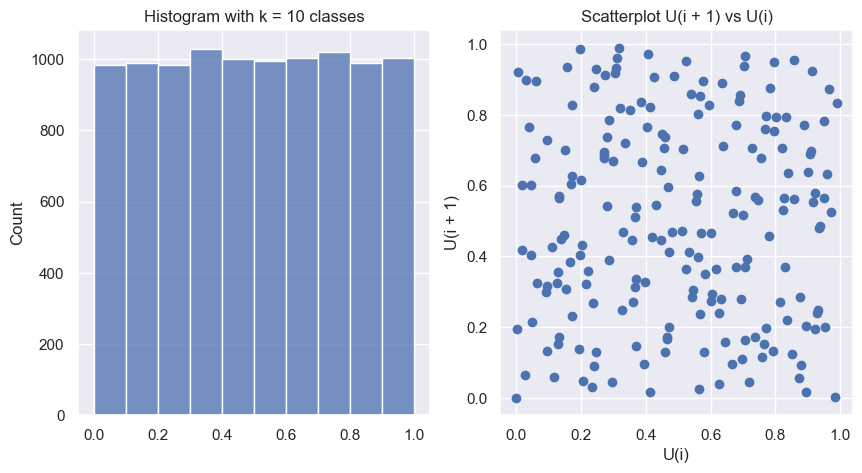

In [17]:
# Parameter values
n = 10000
M = 2 ** 48
a = 25214903917
c = 11
x0 = 3
k = 10 # Number of classes

# Generating
nums = LCG(a, c, M, x0, n)
U = nums / M

# Plotting
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()


In [18]:
run_all_tests(U)

Chi-square test: test-statistic: 9.516000000000002, p-value: 0.9638928369705171
Kolmogorov-Smirnov test: test-statistic: 0.5817708427811435, p-value: 0.8874606871104923
Run test I (Above-Below): test-statistic: 5023, p-value: 0.6454997087450891
Run test II (Up-Down Knuth): test-statistic: 0.9072088201269741, p-value: 0.9888865245268376
Run test III (Up-Down Rubenstein): test-statistic: 0.6562320882129656, p-value: 0.5116748056549036
Correlation test: test-statistic: -0.0049138585147091105, p-value: 0.6232296657981746


Given these parameters for the LCG, the plots indicate that the numbers appear to be uniformly distributed. The vertical bars of the histogram are closely aligned, though not identical, suggesting some pseudo-random variation in sample frequencies. Additionally, the plot on the right shows no discernible pattern between consecutive samples, indicating a lack of correlation.

Regarding the statistical tests, none of them return a p-value larger than $\alpha = 0.05$, leading us to accept the null hypothesis that the sample originates from a uniform distribution.

# *Step 2 Testing python's built in RNG (Mersenne Twister)*

/Users/krzysztofsawicki/opt/anaconda3/envs/ml02450/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/krzysztofsawicki/opt/anaconda3/envs/ml02450/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


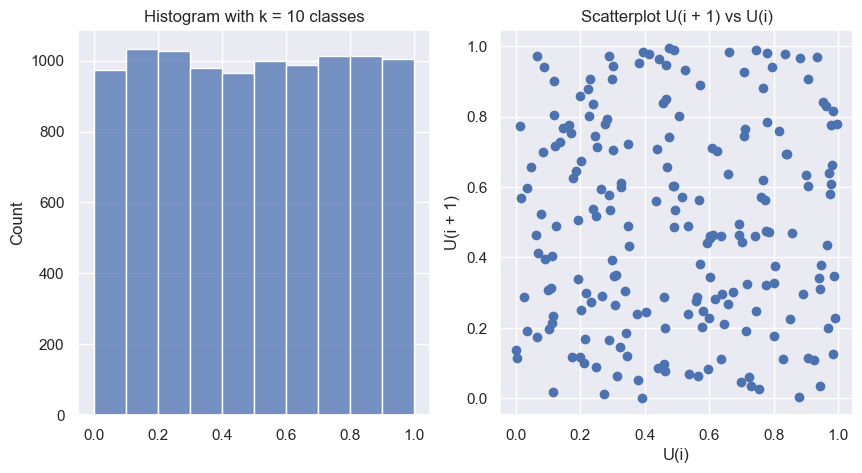

In [19]:
U = np.random.uniform(0, 1, size = 10000)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sbn.histplot(U, bins=k, ax=ax[0])
ax[0].set_title(f"Histogram with k = {k} classes")
ax[1].scatter(U[:200][:-1], U[:200][1:])
ax[1].set_ylabel("U(i + 1)")
ax[1].set_xlabel("U(i)")
ax[1].set_title(f"Scatterplot U(i + 1) vs U(i)")

plt.show()

In [20]:
run_all_tests(U)

Chi-square test: test-statistic: 11.788000000000004, p-value: 0.8944859633890683
Kolmogorov-Smirnov test: test-statistic: 0.5111074251524859, p-value: 0.9563927482324943
Run test I (Above-Below): test-statistic: 5029, p-value: 0.5618950581019284
Run test II (Up-Down Knuth): test-statistic: 8.24032202138064, p-value: 0.22102015921886808
Run test III (Up-Down Rubenstein): test-statistic: -1.241306480113661, p-value: 0.214492551743366
Correlation test: test-statistic: -0.02376284811950463, p-value: 0.017497404313604026


We get the similar results in the previous task. Here, however the bars of the histogram are less alligned.

# *Step 3 Multiple sample test*

A single sample may not provide an accurate evaluation of our RNG's performance due to random fluctuations. To achieve a more dependable assessment, multiple tests should be conducted and their results averaged. Consequently, we sampled ten million numbers using our LCG and applied the Chi-square test in 10,000-number intervals. Ideally, the p-values derived from these tests would be uniformly distributed.

We carried out these experiments employing the parameter values specified in task (1c) and contrasted the outcomes with those from a standard RNG.

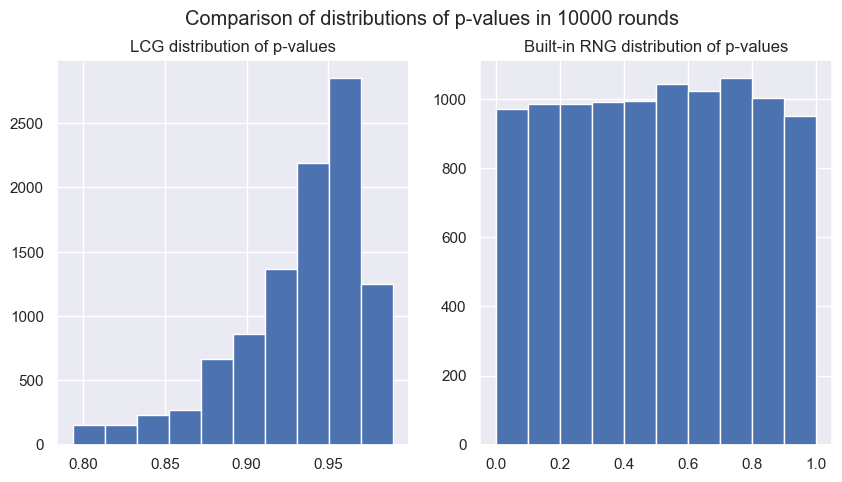

In [21]:
# Parameter values
n = 10000
M = 2 ** 48
a = 25214903917
c = 11
x0 = 3
k = 10 # Number of classes
n_sample = 100000000
rounds = int(n_sample / n)

# Generating
U_lcg = LCG(a = a, c = c, M = M, x0 = x0, n = n_sample)
U = U_lcg / M
U_system = np.random.uniform(0, 1, size = n_sample)


# Initializing storage for p-values from LCG and system build it
p_vals_lcg = np.zeros(rounds)
p_vals_built_in = np.zeros(rounds)

for r in range(rounds):
    u = U[r*n:(r+1)*n]
    _, p = test_chi_square(u, 20)
    p_vals_lcg[r] = p

    u = U_system[r*n:(r+1)*n]
    _, p = test_chi_square(u, 20)
    p_vals_built_in[r] = p

n_bins = 10

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(p_vals_lcg, bins = n_bins)
ax[0].set_title('LCG distribution of p-values')
ax[1].hist(p_vals_built_in, bins = n_bins)
ax[1].set_title('Built-in RNG distribution of p-values')
fig.suptitle(f'Comparison of distributions of p-values in {rounds} rounds')

plt.show()

We see from these results that the p-values of the built-in random number generator are uniformly distributed as would be expected. The p-values of our own implementation using LCG however is not, with values in the range 0.8 - 1.0 only. This indicates that our implementation is not 'random' enough, as we would expect lower p-values for some runs as well.